# Initializing pySpark
We use the package [findspark](https://pypi.org/project/findspark/) in order to init the `SparkContext`. Since we're working with *[DataFrames](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame)* we need to init a `SparkSession` too. The pySpark version is **3.2.0**.<br>
The MovieLens dataset can be found at the following [link](https://files.grouplens.org/datasets/movielens/ml-1m.zip).

In [ ]:
import findspark

findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("MovieLens Dataset").setMaster("local")
sc = SparkContext(conf=conf)
ss = SparkSession(sc)

# Loading the Dataset
## Importing .dat files
The first step is to load the dataset, we can do this using the Pandas `read_table()` [function](https://pandas.pydata.org/docs/reference/api/pandas.read_table.html).<br>
Doing so we obtain 2 DataFrames:
* **Movies**: 3883 x 3
* **Ratings**: 1000209 x 4

In [ ]:
import pandas as pd

movies_pd_dataset = pd.read_table("data/movies.dat", 
                                  delimiter="::", 
                                  names=["MovieID", "Title", "Genres"], 
                                  engine="python")

ratings_pd_dataset = pd.read_table("data/ratings.dat", 
                                   delimiter="::", 
                                   names=["UserID", "MovieID", "Rating", "Timestamp"], 
                                   engine="python")

## Creating a Schema
In order to simplify the access to our DataFrames we provide a custom [schema](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.types.StructType.html) to the `createDataFrame()` [function](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html#pyspark.sql.SparkSession.createDataFrame).<br>
As a result of this operation is possible to specify which data [type](https://spark.apache.org/docs/latest/api/python/search.html?q=PySpark.sql.types#) we want to use for each column, reducing the space used by our DataFrames.

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, ShortType, IntegerType

movies_schema = StructType([
    StructField("MovieID", ShortType(), False),
    StructField("Title", StringType(), False),
    StructField("Genres", StringType(), False)
])

ratings_schema = StructType([
    StructField("UserID", ShortType(), False),
    StructField("MovieID", ShortType(), False),
    StructField("Rating", ShortType(), False),
    StructField("Timestamp", IntegerType(), False)
])

movies_dataset = ss.createDataFrame(movies_pd_dataset, schema=movies_schema)
ratings_dataset = ss.createDataFrame(ratings_pd_dataset, schema=ratings_schema)

# Exploratory Analysis

## Query 1
Find the *number of ratings* and *distribution* for each movie

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("MovieID").count().orderBy("MovieID")\
               .select("count").show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("MovieID").count()
                   .orderBy("MovieID")\
                   .select("count").toPandas(),
    hist=False,
    kde=True
)

plt.show()

## Query 2
Find the *number of ratings* and *distribution* for each user

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of ratings
ratings_dataset.groupBy("UserID").count().orderBy("UserID")\
               .select("count").show()

# Distribution plot
plt.figure(figsize=(16,9))

sns.distplot(
    ratings_dataset.groupBy("UserID").count()
                   .orderBy("UserID")\
                   .select("count").toPandas(),
    hist=False,
    kde=True
)

plt.show()

## Query 3
Find the *average score* recieved by each movie

In [ ]:
from pyspark.sql.functions import format_number

ratings_dataset.groupBy("MovieID").agg({"Rating": "mean"})\
               .orderBy("MovieID")\
               .select(
                   "MovieID", 
                   format_number("avg(Rating)", 4).alias("Average")
               )\
               .show()

## Query 4
Find the *average score* given by each user 

In [ ]:
ratings_dataset.groupBy("UserID").agg({"Rating": "mean"})\
               .orderBy("UserID")\
               .select(
                   "UserID", 
                   format_number("avg(Rating)", 4).alias("Average")
               )\
               .show()

## Query 5
Top **K** movies with at least **R** ratings

In [ ]:
from pyspark.sql.functions import col

# Number of movies to show in the result
K = 10

# Minimum number of ratings each movie should have
R = 20

movies_dataset.join(ratings_dataset, "MovieID").groupBy("MovieID").count()\
              .orderBy("MovieID").withColumnRenamed("count", "Number of Ratings")\
              .filter(col("Number of Ratings") >= R).limit(K).show()

# Queries

## Query 1
Find if there is a correlation between the *standard deviation* of the **ratings** a movie has received, and the *number of ratings*.<br><br>
As shown in the plot, reducing the number of movies slightly alters the density of the data, but not in the way we expect. That's beacause instead of being distributed "*normally*" (following a **Normal Distribution**) as proven by the *Skewness* results at the bootom of the plot, the data follows a **Paretian Distribution** (as we can se from the side-to-side comparison below the distribution plot).

21/12/02 21:25:35 WARN TaskSetManager: Stage 1142 contains a task of very large size (15557 KiB). The maximum recommended task size is 1000 KiB.
21/12/02 21:25:36 WARN TaskSetManager: Stage 1148 contains a task of very large size (15557 KiB). The maximum recommended task size is 1000 KiB.
21/12/02 21:25:36 WARN TaskSetManager: Stage 1154 contains a task of very large size (15557 KiB). The maximum recommended task size is 1000 KiB.
21/12/02 21:25:37 WARN TaskSetManager: Stage 1160 contains a task of very large size (15557 KiB). The maximum recommended task size is 1000 KiB.
/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/pyspark/lib/python3.9/s

<Figure size 432x288 with 0 Axes>

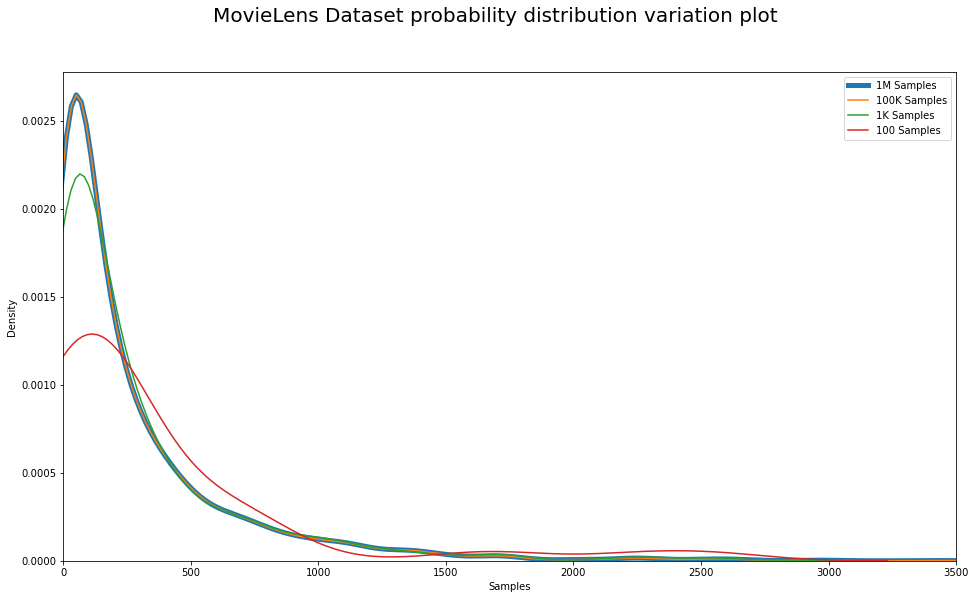

Skewness 1M samples: [0.]
Skewness 100K samples: [0.]
Skewness 1K samples: [8.78198508e-96]
Skewness 100 samples: [1.04995273e-12]


In [120]:
import matplotlib.pyplot as plt
from scipy.stats import skew, skewtest
import seaborn as sns

one_M_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .withColumnRenamed("count", "Number of Ratings")\
                              .select("Number of Ratings")\
                              .toPandas()

hundred_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                  .groupBy("MovieID").count()\
                                  .withColumnRenamed("count", "Number of Ratings")\
                                  .select("Number of Ratings")\
                                  .limit(100000)\
                                  .toPandas()

one_K_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                              .groupBy("MovieID").count()\
                              .withColumnRenamed("count", "Number of Ratings")\
                              .select("Number of Ratings")\
                              .limit(1000)\
                              .toPandas()

hundred_samples = movies_dataset.join(ratings_dataset, "MovieID")\
                                .groupBy("MovieID").count()\
                                .withColumnRenamed("count", "Number of Ratings")\
                                .select("Number of Ratings")\
                                .limit(100)\
                                .toPandas()

plt.clf()

fig = plt.figure(figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset probability distribution variation plot", 
    fontsize=20
)

sns.distplot(
    one_M_samples,
    hist=False,
    kde=True,
    kde_kws={"linewidth": 5},
    label="1M Samples"
)

sns.distplot(
    hundred_K_samples,
    hist=False,
    kde=True,
    label="100K Samples"
)

sns.distplot(
    one_K_samples,
    hist=False,
    kde=True,
    label="1K Samples"
)

sns.distplot(
    hundred_samples,
    hist=False,
    kde=True,
    label="100 Samples"
)

plt.legend()
plt.xlabel("Samples")
plt.xlim([0, 3500])

plt.show()

print(f"Skewness 1M samples: {skewtest(one_M_samples)[1]}")
print(f"Skewness 100K samples: {skewtest(hundred_K_samples)[1]}")
print(f"Skewness 1K samples: {skewtest(one_K_samples)[1]}")
print(f"Skewness 100 samples: {skewtest(hundred_samples)[1]}")

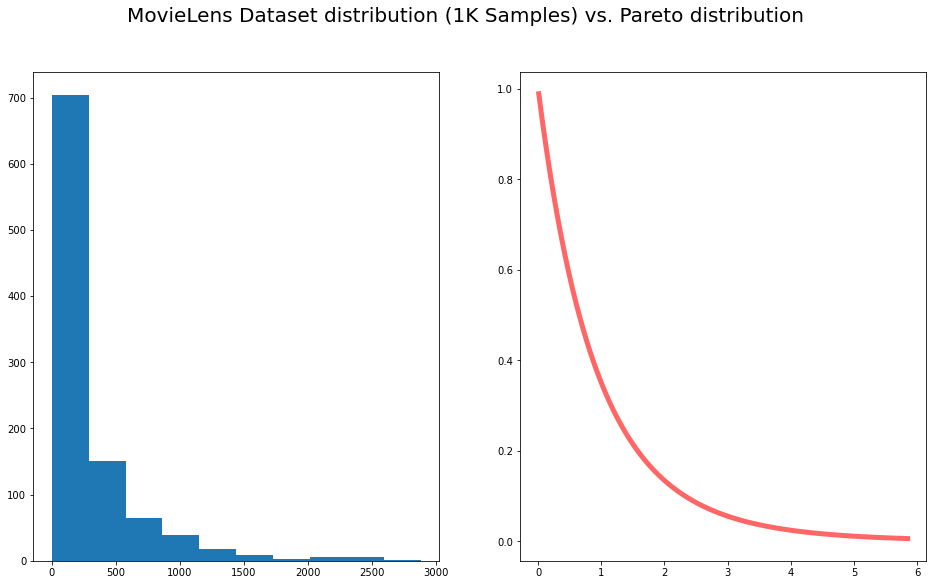

In [118]:
import numpy as np
from scipy.stats import genpareto

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fig.suptitle(
    "MovieLens Dataset distribution (1K Samples) vs. Pareto distribution",
    fontsize=20
)

ax1.hist(one_K_samples)

c = 0.1

mean, var, skew, kurt = genpareto.stats(c, moments='mvsk')
x = np.linspace(genpareto.ppf(0.01, c), genpareto.ppf(0.99, c), 100)

ax2.plot(x, genpareto.pdf(x, c), 'r-', lw=5, alpha=0.6, label='genpareto pdf')

plt.show()